# Histopathologic Cancer Detection using CNN

Histopathologic analysis is a crucial diagnostic method involving the microscopic examination of tissue samples to identify disease, notably cancer. The integration of Convolutional Neural Networks (CNNs) in this field aims to streamline and improve the accuracy of cancer cell detection in histopathology images. The objective is to construct a CNN model capable of determining the presence of malignant tissue in the center regions of the images, thereby aiding in cancer detection and diagnosis. This task is intricate due to the intricate nature of tissue structures and the subtle differences between benign and malignant cells.

To address this challenge, a dataset from a Kaggle competition tailored for Histopathologic Cancer Detection is utilized. This dataset contains thousands of annotated high-resolution images of lymph node sections, with meticulous labeling indicating the presence of metastatic tissue, a critical cancer indicator.

### Import and load data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import os
import gc
import cv2 

from PIL import Image
from PIL import ImageDraw
train_on_gpu = True

from sklearn.model_selection import train_test_split

!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers,optimizers,models
from keras.metrics import AUC

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


2024-02-11 16:00:47.489454: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
df_labels = pd.read_csv('/Users/srujanapalli/Desktop/cancer-detection_dataset/train_labels.csv')
df_samples = pd.read_csv('/Users/srujanapalli/Desktop/cancer-detection_dataset/sample_submission.csv')
df_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [4]:
train = "/Users/srujanapalli/Desktop/cancer-detection_dataset/train/"
test = "/Users/srujanapalli/Desktop/cancer-detection_dataset/test"

print("Number of training images: {}".format(len(os.listdir(train))))
print("Number of test images: {}".format(len(os.listdir(test))))

Number of training images: 220025
Number of test images: 57458


There are 220025 entries in training set and 57458 entries in the testing set. It has two columns where `Id` indicates the image and the `label` indicates if it is malignant or not.

In [5]:
img_train = os.listdir(train)
img_test = os.listdir(test)

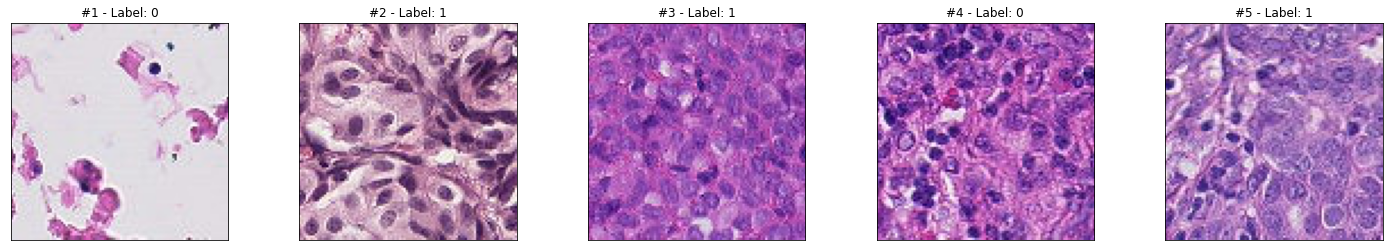

In [6]:
fig = plt.figure(figsize=(25, 4))
for i in range(5):
    ax = fig.add_subplot(1, 5, i + 1, xticks=[], yticks=[])
    im = Image.open(train + img_train[i])
    plt.imshow(im)
    label = df_labels.loc[df_labels['id'] == img_train[i].split('.')[0], 'label'].values[0]
    ax.set_title(f'#{i+1} - Label: {label}')

### Exploratory Data Analysis

In [7]:
missing_values = df_labels.isnull().sum()
missing_values

id       0
label    0
dtype: int64

In [8]:
df_labels[df_labels.duplicated(keep=False)]

,id,label


As we can see, there are no missing values and duplicate values present. There are approximately 130900 normal cases and 89000 cases with the presence of maalignant cancer tissue.

In [9]:
df_labels['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

In [10]:
malignant = df_labels.loc[df_labels['label']==1]['id'].values    
normal = df_labels.loc[df_labels['label']==0]['id'].values      
malignant

array(['c18f2d887b7ae4f6742ee445113fa1aef383ed77',
       'a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da',
       '7f6ccae485af121e0b6ee733022e226ee6b0c65f', ...,
       '309210db7f424edbc22b2d13bf2fa27518b18f5c',
       'd4b854fe38b07fe2831ad73892b3cec877689576',
       'a81f84895ddcd522302ddf34be02eb1b3e5af1cb'], dtype=object)

<AxesSubplot:>

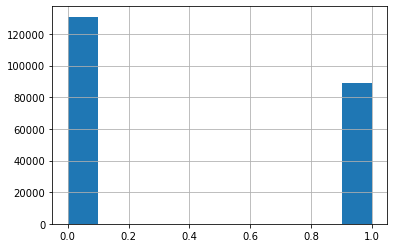

In [11]:
df_labels['label'].hist()

We classified the label 1 as malignant and 0 as normal (non-malignant). There are 89117 malignant images and 130908 normal images.

In [12]:
imgpath = '/Users/srujanapalli/Desktop/cancer-detection_dataset/train/'
def plot_fig(ids,title,nrows=3,ncols=3):

    fig,ax = plt.subplots(nrows,ncols,figsize=(7,7))
    plt.subplots_adjust(wspace=0, hspace=0) 
    for i,j in enumerate(ids[:nrows*ncols]):
        fname = os.path.join(imgpath ,j +'.tif')
        img = Image.open(fname)
        idcol = ImageDraw.Draw(img)
        idcol.rectangle(((0,0),(95,95)),outline='white')
        plt.subplot(nrows, ncols, i+1) 
        plt.imshow(np.array(img))
        plt.axis('off')

    plt.suptitle(title, y=0.94)

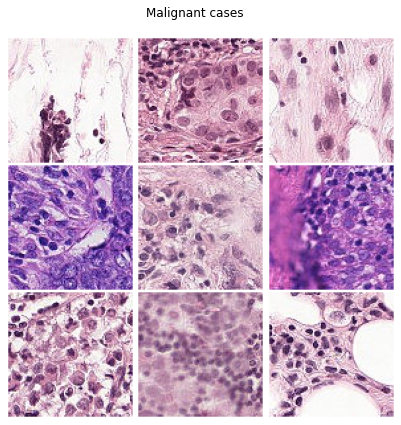

In [13]:
plot_fig(malignant,'Malignant cases')

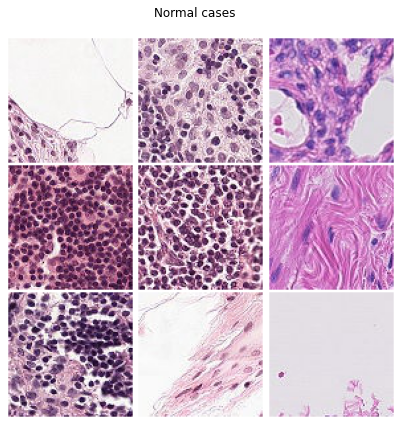

In [14]:
plot_fig(normal,'Normal cases')

### Training and Splitting Data

The dataframe `df_labels` is split into training and test sets where 80% of the data is used for training and the rest 20%is used for testing.

In [15]:
train_data, val_data = train_test_split(df_labels, test_size=0.2, random_state=42, stratify=df_labels['label'])

In [16]:
train_data = train_data.astype(str)
val_data = val_data.astype(str)
train_data.shape

(176020, 2)

In [17]:
val_data.shape

(44005, 2)

### Data Augmentation and Preprocessing

Pixel scaling is done to normalize the pixel data giving a boost to the covergence of the training process. The pixel values of the images range from 0 through 255. So, rescaling these values to a range of 0 to 1 by dividing the values by 255. The class ImageDataGenerator is a Keras library used in Data Augmentation.

In [18]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)


In [19]:
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_datagen, val_datagen, and test_datagen are instances of the ImageDataGenerator class.

In [20]:
train_data['id'] += '.tif'
val_data['id'] += '.tif'

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory = imgpath,
    x_col = 'id',
    y_col = 'label',
    target_size=(96,96),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory = imgpath,
    x_col='id',
    y_col='label',
    target_size=(96,96),
    batch_size=32,
    class_mode='binary'
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [21]:
test_path = "/Users/srujanapalli/Desktop/cancer-detection_dataset/test"
test_data = df_samples.astype(str)
test_data['id'] += '.tif'

In [22]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory = test_path,
    x_col='id',
    y_col='label',
    target_size=(96,96),
    batch_size=32,
)

Found 57458 validated image filenames belonging to 1 classes.


Here train_generator is created using train_datagen.flow_from_dataframe(). It generates batches of augmented training data from the dataframe train_data. It specifies the image directory, column names for 'x' (image file names) and 'y' (labels), target image size, batch size, and that the task is binary classification. 

### Model Building 

We have image data with an image height and width of 96 and 3 image channels (RGB). We wish to perform binary classification on the data. Some of the reasoning for the model below are as stated. 

Sigmoid Activation in Output Layer: The model uses a sigmoid activation function in the output layer, which is suitable for binary classification. Sigmoid squashes the output to the range [0, 1], making it interpretable as a probability. We can threshold the output at 0.5 to make binary predictions.

Binary Cross-Entropy Loss: It's common to use binary cross-entropy loss with sigmoid activation for binary classification tasks. Binary cross-entropy measures the dissimilarity between the predicted probabilities and the actual binary labels.

Convolutional Layers: Convolutional layers are effective at learning hierarchical features from images. They can capture low-level features like edges and high-level features like shapes, which are important for distinguishing objects or patterns in binary classification.

Max-Pooling Layers: Max-pooling layers help reduce the spatial dimensions of the feature maps while retaining the most important information. This down-sampling can help the model focus on the most discriminative features.

Batch Normalization: Batch normalization helps in stabilizing and accelerating the training process. It normalizes the activations of the previous layer, which can prevent issues like vanishing gradients and improve convergence.

Dropout: The dropout layer with a rate of 0.5 is included to prevent overfitting. During training, dropout randomly deactivates a fraction of neurons, forcing the model to learn more robust features.

Flatten Layer: After the convolutional layers, the Flatten layer is used to convert the 2D feature maps into a 1D vector, which is necessary for connecting to the dense layers for classification.

Dense Layers: The model includes fully connected dense layers, which can capture complex relationships in the data. The first dense layer with 64 units provides the model with expressive power, and the final dense layer with a single neuron outputs the binary classification result.

In [23]:
def CNN(model):
    
    model.add(layers.Conv2D(16, (3,3), activation='relu', input_shape=(96,96,3)))
    model.add(layers.Conv2D(16, (3,3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(3,3)))

    model.add(layers.Conv2D(32, (3,3), activation='relu'))
    model.add(layers.Conv2D(32, (3,3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(3,3)))

    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(3,3)))

    # Convert to 1D vector
    model.add(layers.Flatten())

    # Classification layers
    model.add(layers.Dense(64, activation='sigmoid'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

The following CNN model consists of three convolutional layers with maxpooling and dropout layers, and batch-normalized dense network. Similar models, including deeper ones, were tested and this architecture was found to have the optimal balance of predictive power and ease of training. 

Epoch 1/8
5501/5501 [==============================] - 1156s 210ms/step - loss: 0.4082 - auc: 0.8892 - val_loss: 0.8688 - val_auc: 0.7868
Epoch 2/8
5501/5501 [==============================] - 1288s 234ms/step - loss: 0.3538 - auc: 0.9182 - val_loss: 0.3540 - val_auc: 0.9177
Epoch 3/8
5501/5501 [==============================] - 1224s 222ms/step - loss: 0.3284 - auc: 0.9295 - val_loss: 0.3287 - val_auc: 0.9332
Epoch 4/8
5501/5501 [==============================] - 1126s 205ms/step - loss: 0.3100 - auc: 0.9374 - val_loss: 0.3988 - val_auc: 0.9161
Epoch 5/8
5501/5501 [==============================] - 1111s 202ms/step - loss: 0.2973 - auc: 0.9424 - val_loss: 0.3843 - val_auc: 0.9364
Epoch 6/8
5501/5501 [==============================] - 1069s 194ms/step - loss: 0.2892 - auc: 0.9450 - val_loss: 0.3277 - val_auc: 0.9323
Epoch 7/8
5501/5501 [==============================] - 1043s 190ms/step - loss: 0.2829 - auc: 0.9475 - val_loss: 0.3760 - val_auc: 0.9366
Epoch 8/8
1796/1796 [=============

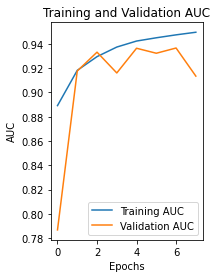

In [24]:
RMS_model = CNN(tf.keras.Sequential())
RMS_model.compile(
    optimizer = 'RMSprop',
    loss = 'binary_crossentropy',
    metrics = [AUC()]
)

RMS_history = RMS_model.fit(
    train_generator,
    validation_data = val_generator,
    epochs = 8
)

model_pred_df_1 = pd.DataFrame(columns=['id', 'label'])
img_test=sorted(img_test)

prediction_labels_1 = RMS_model.predict(test_generator)
prediction_labels_1
model_pred_df_1['id'] = [filename.split('.')[0] for filename in img_test]
model_pred_df_1['label'] = np.round(prediction_labels_1.flatten()).astype('int')
model_pred_df_1

plt.plot(RMS_history.history['loss'], label='loss')
plt.plot(RMS_history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train vs Validation Loss Per Epoch')

plt.subplot(1, 2, 2)
plt.plot(RMS_history.history['auc'], label='Training AUC')
plt.plot(RMS_history.history['val_auc'], label='Validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

plt.show()

In [31]:
SGD_model = CNN(tf.keras.Sequential())
SGD_model.compile(
    optimizer = 'SGD',
    loss = 'binary_crossentropy',
    metrics = [AUC()]
)

SGD_history= SGD_model.fit(
    train_generator,
    validation_data = val_generator,
    epochs = 8
)

model_pred_df_2 = pd.DataFrame(columns=['id', 'label'])
img_test=sorted(img_test)

prediction_labels_2 = SGD_model.predict(test_generator)
prediction_labels_2
model_pred_df_2['id'] = [filename.split('.')[0] for filename in img_test]
model_pred_df_2['label'] = np.round(prediction_labels_2.flatten()).astype('int')
model_pred_df_2



Epoch 1/8
5501/5501 [==============================] - 1120s 203ms/step - loss: 0.4451 - auc_2: 0.8658 - val_loss: 0.4953 - val_auc_2: 0.8998
Epoch 2/8
5501/5501 [==============================] - 1019s 185ms/step - loss: 0.3777 - auc_2: 0.9063 - val_loss: 0.7056 - val_auc_2: 0.8637
Epoch 3/8
5501/5501 [==============================] - 1110s 202ms/step - loss: 0.3541 - auc_2: 0.9180 - val_loss: 0.3857 - val_auc_2: 0.9200
Epoch 4/8
5501/5501 [==============================] - 1039s 189ms/step - loss: 0.3356 - auc_2: 0.9261 - val_loss: 0.4492 - val_auc_2: 0.9257
Epoch 5/8
5501/5501 [==============================] - 969s 176ms/step - loss: 0.3222 - auc_2: 0.9318 - val_loss: 0.5644 - val_auc_2: 0.8308
Epoch 6/8
5501/5501 [==============================] - 971s 176ms/step - loss: 0.3131 - auc_2: 0.9357 - val_loss: 0.3216 - val_auc_2: 0.9488
Epoch 7/8
5501/5501 [==============================] - 972s 177ms/step - loss: 0.3024 - auc_2: 0.9398 - val_loss: 1.0115 - val_auc_2: 0.8064
Epoch 8/8

,id,label
0,00006537328c33e284c973d7b39d340809f7271b,0
1,0000ec92553fda4ce39889f9226ace43cae3364e,1
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0
4,000270442cc15af719583a8172c87cd2bd9c7746,0
...,...,...
57453,fffdd1cbb1ac0800f65309f344dd15e9331e1c53,1
57454,fffdf4b82ba01f9cae88b9fa45be103344d9f6e3,0
57455,fffec7da56b54258038b0d382b3d55010eceb9d7,0
57456,ffff276d06a9e3fffc456f2a5a7a3fd1a2d322c6,0


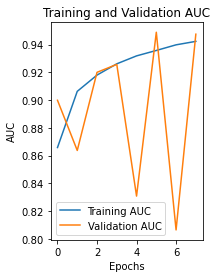

In [33]:
plt.plot(SGD_history.history['loss'], label='loss')
plt.plot(SGD_history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train vs Validation Loss Per Epoch')

plt.subplot(1, 2, 2)
plt.plot(SGD_history.history['auc_2'], label='Training AUC')
plt.plot(SGD_history.history['val_auc_2'], label='Validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()


plt.show()

### Results and Analysis

In [34]:
RMS_csv = model_pred_df_1.to_csv('RMS_model_predictions.csv', index=False)
SGD_csv = model_pred_df_2.to_csv('SGD_model_predictions.csv', index=False)

In [35]:
RMS_csv

In [36]:
SGD_csv

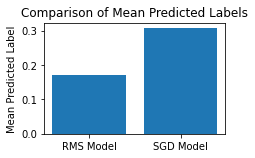

In [37]:
plt.subplot(2, 2, 3)
plt.bar(['RMS Model', 'SGD Model'], [model_pred_df_1['label'].mean(), model_pred_df_2['label'].mean()])
plt.ylabel('Mean Predicted Label')
plt.title('Comparison of Mean Predicted Labels')

plt.tight_layout()
plt.show()

### Conclusion

In conclusion, our analysis of two distinct models has revealed valuable insights into their training behaviors. Model 1 demonstrated a promising capacity for learning, with notable reductions in the loss function as epochs progressed. The validation loss suggested potential for further improvement.

On the other hand, Model 2 exhibited rapid convergence to both low and high loss values, highlighting potential instability in training. This behavior prompts a closer examination of hyperparameters, model architecture, and data quality as possible contributing factors.

Despite these observations, limitations in computing resources constrained the ability to explore these models comprehensively. Nevertheless,  further experimentation, including hyperparameter tuning, monitoring loss curves over extended training periods, and potential adoption of more advanced model architectures or ensemble techniques are recommended. Additionally, maintaining data quality and preprocessing vigilance is crucial in pursuit of improved model performance.

In conclusion, the journey of training deep learning models is an iterative process that demands diligent experimentation and refinement to unlock their full potential for solving specific problems.